In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import shap 
plt.style.use('ggplot')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/experiments/alifbanktest/credit_train.csv', sep=';', encoding="cp1251", index_col='client_id')
blindSet = pd.read_csv('/content/drive/MyDrive/experiments/alifbanktest/credit_test.csv', sep=';', encoding="cp1251", index_col='client_id')

In [ ]:
df['score_shk'].replace(',', '.', regex=True, inplace=True)
df['credit_sum'].replace(',', '.', regex=True, inplace=True)
df = df.astype({'credit_sum': float, 'score_shk': float})

In [ ]:
df.head(5)

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
client_id,,,,,,,,,,,,,,
1,M,48,MAR,UMN,59998.00,10,1.6,0.770249,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
2,F,28,MAR,UMN,10889.00,6,1.1,0.248514,GRD,МОСКВА,43000.0,2.0,0.0,0
3,M,32,MAR,SPC,10728.00,12,1.1,0.459589,SCH,ОБЛ САРАТОВСКАЯ,23000.0,5.0,0.0,0
4,F,27,DIV,SPC,12009.09,12,1.1,0.362536,GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0
5,M,45,MAR,SPC,16908.89,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170746 entries, 1 to 170746
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170746 non-null  int64  
 2   marital_status        170746 non-null  object 
 3   job_position          170746 non-null  object 
 4   credit_sum            170746 non-null  float64
 5   credit_month          170746 non-null  int64  
 6   tariff_id             170746 non-null  float64
 7   score_shk             170746 non-null  float64
 8   education             170746 non-null  object 
 9   living_region         170554 non-null  object 
 10  monthly_income        170745 non-null  float64
 11  credit_count          161516 non-null  float64
 12  overdue_credit_count  161516 non-null  float64
 13  open_account_flg      170746 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 19.

In [ ]:
df.shape

(170746, 14)

In [ ]:
df.isnull().sum()

gender                     0
age                        0
marital_status             0
job_position               0
credit_sum                 0
credit_month               0
tariff_id                  0
score_shk                  0
education                  0
living_region            192
monthly_income             1
credit_count            9230
overdue_credit_count    9230
open_account_flg           0
dtype: int64

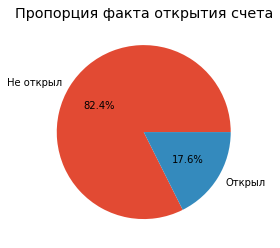

In [ ]:
plt.pie(df['open_account_flg'].value_counts(), labels = ['Не открыл', 'Открыл'], autopct = '%1.1f%%')
plt.title('Пропорция факта открытия счета')
plt.show()

In [ ]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160238 entries, 1 to 170746
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                160238 non-null  object 
 1   age                   160238 non-null  int64  
 2   marital_status        160238 non-null  object 
 3   job_position          160238 non-null  object 
 4   credit_sum            160238 non-null  float64
 5   credit_month          160238 non-null  int64  
 6   tariff_id             160238 non-null  float64
 7   score_shk             160238 non-null  float64
 8   education             160238 non-null  object 
 9   living_region         160238 non-null  object 
 10  monthly_income        160238 non-null  float64
 11  credit_count          160238 non-null  float64
 12  overdue_credit_count  160238 non-null  float64
 13  open_account_flg      160238 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 18.

In [ ]:
numerical = ['age', 'credit_sum', 'credit_month', 
             'tariff_id', 'score_shk', 'monthly_income', 'credit_count','overdue_credit_count']

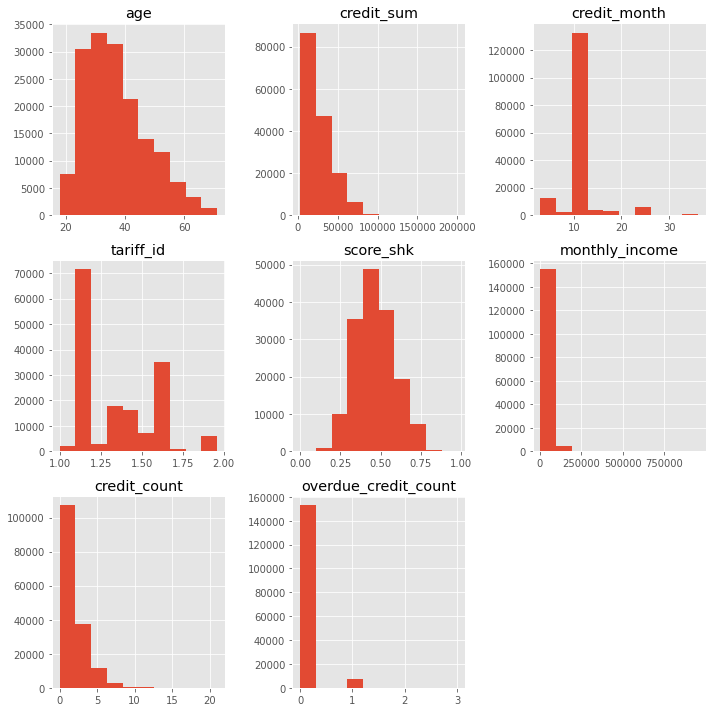

In [ ]:
df[numerical].hist(figsize = (10,10))
plt.tight_layout()

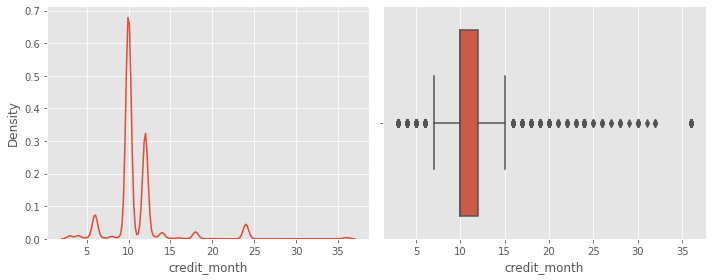

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))
sns.kdeplot(df['credit_month'], ax = ax1)
sns.boxplot(x = df['credit_month'], ax = ax2)
plt.tight_layout()

In [ ]:
def remove_outliers(df, columns):
  for i in columns:
    df = df[np.abs(df[i]-df[i].mean()) <= (3*df[i].std())]
  return df
# keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
df_new = remove_outliers(df, numerical)

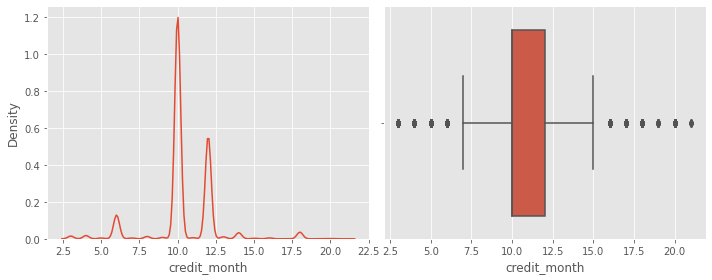

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))
sns.kdeplot(df_new['credit_month'], ax = ax1)
sns.boxplot(x = df_new['credit_month'], ax = ax2)
plt.tight_layout()

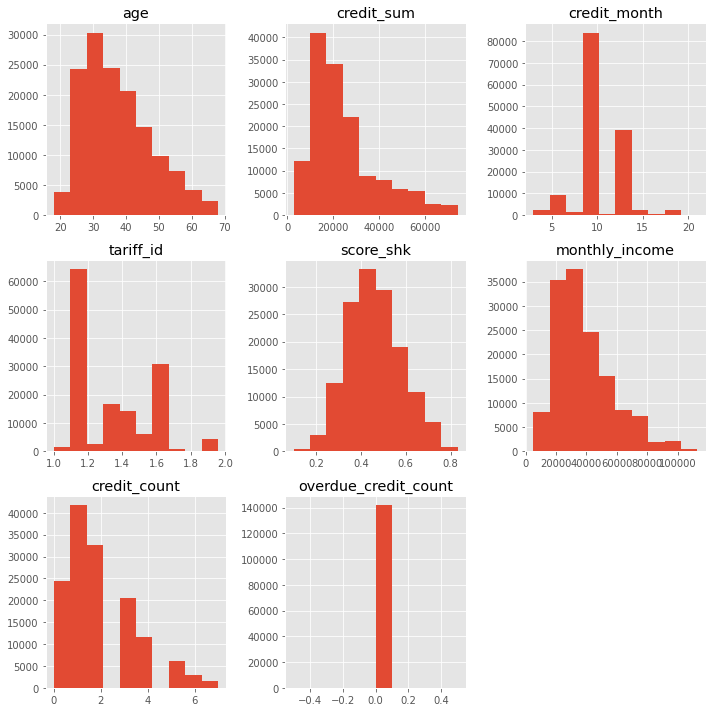

In [ ]:
df_new[numerical].hist(figsize = (10,10))
plt.tight_layout()

# Future Engineering

In [ ]:
criteria = [df_new['monthly_income'].between(0, 25000), df_new['monthly_income'].between(25000, 65000), df_new['monthly_income'] > 65000]
values = ['low', 'median', 'high']
df_new['monthly_income_cat'] = np.select(criteria, values, 0)

In [ ]:
# Средний доход с учетом региона
mean_inc_reg = df_new.groupby('living_region')['monthly_income'].median().to_dict()
df_new['mean_income_region'] = df_new['living_region'].map(mean_inc_reg)

# Средний доход с учетом возраста
mean_inc_reg = df_new.groupby('age')['monthly_income'].median().to_dict()
df_new['mean_income_age'] = df_new['age'].map(mean_inc_reg)

# Средний score bki с учетом возраста
mean_inc_reg = df_new.groupby('age')['score_shk'].median().to_dict()
df_new['mean_shk_age'] = df_new['age'].map(mean_inc_reg)


In [ ]:
encoded_dataset = pd.get_dummies(
    df_new, 
    columns=[
        'gender',
        'marital_status',
        'job_position',
        'education',
        'living_region',
        # 'monthly_income_cat'
        ]
)

In [ ]:
RAND = 10

In [ ]:
X = df_new.drop('open_account_flg', axis=1)
y = df_new['open_account_flg']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, shuffle=True, random_state=RAND)

In [ ]:
X_train = pd.get_dummies(
    X_train, 
    columns=[
        'gender',
        'marital_status',
        'job_position',
        'education',
        'living_region',
        # 'monthly_income_cat'
        ]
)

In [ ]:
X_test = pd.get_dummies(
    X_test, 
    columns=[
        'gender',
        'marital_status',
        'job_position',
        'education',
        'living_region',
        # 'monthly_income_cat'
        ]
)

In [ ]:
X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

In [ ]:
RS_CV = 3
RS_N_ITER = 10
RS_N_JOBS = -1
RS_SCORING = 'roc_auc'
model = CatBoostClassifier()
parameters = {'depth': list(range(1, 10)),
              'learning_rate': [0.001, 0.01, 0.02, 0.03, 1.0],
              'l2_leaf_reg': [10, 15, 25, 30, 40],
              'random_strength': [0.3, 0.5, 0.7, 1.0], 
              'n_estimators': [200, 500, 700, 1000] 
             }

rs = RandomizedSearchCV(estimator=model, 
                           param_distributions = parameters,
                           scoring=RS_SCORING,
                           cv = RS_CV, 
                           n_iter = RS_N_ITER, 
                           n_jobs=RS_N_JOBS)
rs.fit(X_train, y_train)

# лучшие параметры
print(rs.best_params_)
bestModel = rs.best_estimator_

In [ ]:
clf = CatBoostClassifier(
    learning_rate=0.03, 
    depth=9, 
    l2_leaf_reg=30, 
    random_strength=1.0, 
    n_estimators=1000, 
    eval_metric='AUC',

)
clf.fit(X_train, y_train, verbose=False)

In [ ]:
prediction = clf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn import metrics
print(classification_report(y_test, prediction))
print()
print(confusion_matrix(y_test, prediction))
print()
fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
print('AUC:', metrics.auc(fpr, tpr))
print('ACC', metrics.accuracy_score(y_test, prediction))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     29712
           1       0.55      0.05      0.10      5730

    accuracy                           0.84     35442
   macro avg       0.70      0.52      0.51     35442
weighted avg       0.80      0.84      0.78     35442


[[29455   257]
 [ 5418   312]]

AUC: 0.7577557495528922
ACC 0.8398792393205801


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


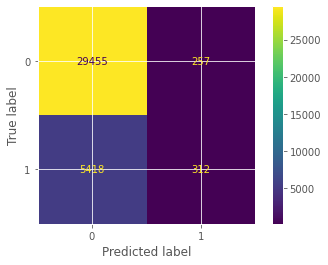

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

In [ ]:
#Future importance
shap.initjs()

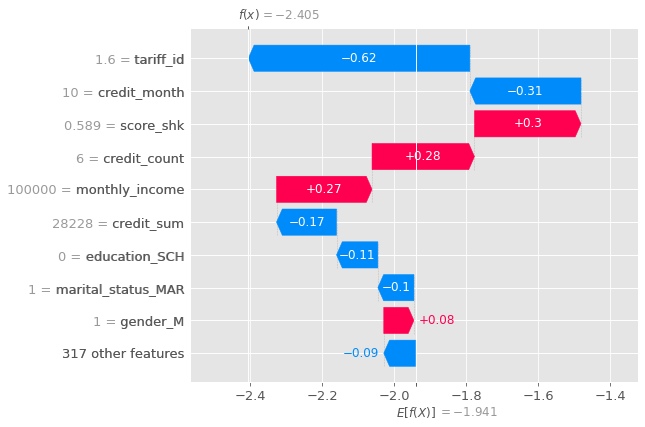

In [ ]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[0])

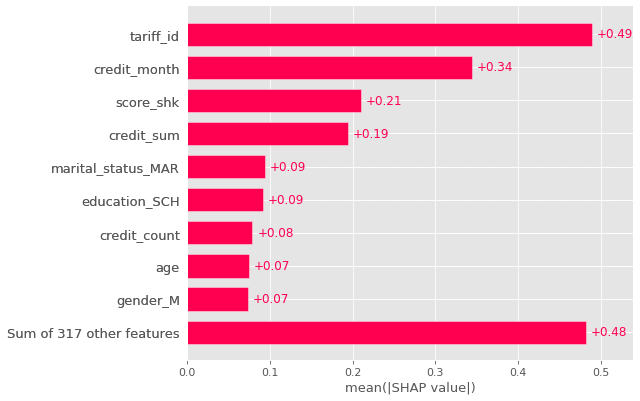

In [ ]:
shap.plots.bar(shap_values)

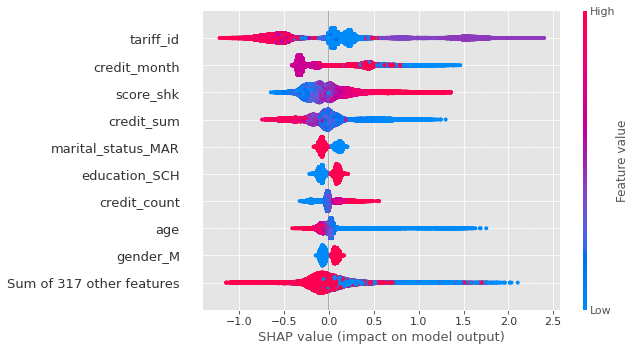

In [ ]:
shap.plots.beeswarm(shap_values)

# Балансировка классов

<h3> Первый способ менять scale_pos_weigh</h3>

In [ ]:
clf_scale = CatBoostClassifier(
    learning_rate=0.03, 
    depth=9, 
    l2_leaf_reg=30, 
    random_strength=1.0, 
    n_estimators=1000, 
    eval_metric='AUC',
    scale_pos_weight = 5

)
clf_scale.fit(X_train, y_train, verbose=False)

In [ ]:
prediction = clf_scale.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn import metrics
print(classification_report(y_test, prediction))
print()
print(confusion_matrix(y_test, prediction))
print()
fpr, tpr, thresholds = metrics.roc_curve(y_test, clf_scale.predict_proba(X_test)[:,1])
print('AUC:', metrics.auc(fpr, tpr))
print('ACC', metrics.accuracy_score(y_test, prediction))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80     29712
           1       0.31      0.68      0.43      5730

    accuracy                           0.71     35442
   macro avg       0.62      0.69      0.61     35442
weighted avg       0.82      0.71      0.74     35442


[[21111  8601]
 [ 1848  3882]]

AUC: 0.757315649079329
ACC 0.7051802945657695


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


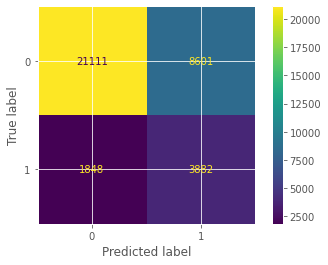

In [ ]:
plot_confusion_matrix(clf_scale, X_test, y_test)  
plt.show()

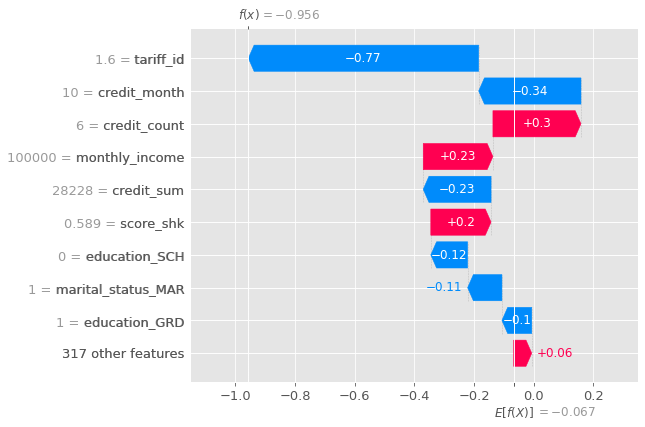

In [ ]:
explainer = shap.Explainer(clf_scale)
shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[0])

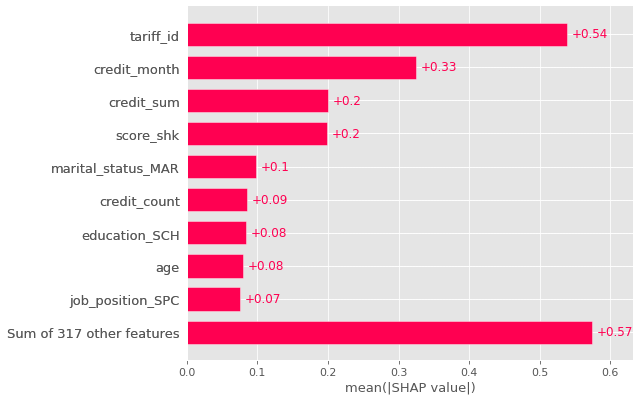

In [ ]:
shap.plots.bar(shap_values)

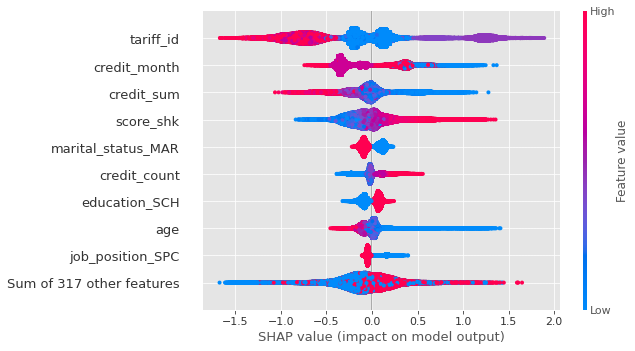

In [ ]:
shap.plots.beeswarm(shap_values)

<h3> Второй способ считать class_weights</h3>

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [ ]:
clf_weighted = CatBoostClassifier(
    learning_rate=0.03, 
    depth=9, 
    l2_leaf_reg=30, 
    random_strength=1.0, 
    n_estimators=1000, 
    eval_metric='AUC',
    class_weights=class_weights

)
clf_weighted.fit(X_train, y_train, verbose=False)

In [ ]:
prediction = clf_weighted.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn import metrics
print(classification_report(y_test, prediction))
print()
print(confusion_matrix(y_test, prediction))
print()
fpr, tpr, thresholds = metrics.roc_curve(y_test, clf_weighted.predict_proba(X_test)[:,1])
print('AUC:', metrics.auc(fpr, tpr))
print('ACC', metrics.accuracy_score(y_test, prediction))

              precision    recall  f1-score   support

           0       0.92      0.70      0.80     29712
           1       0.31      0.69      0.43      5730

    accuracy                           0.70     35442
   macro avg       0.61      0.69      0.61     35442
weighted avg       0.82      0.70      0.74     35442


[[20860  8852]
 [ 1790  3940]]

AUC: 0.7571533228593098
ACC 0.6997347779470684


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


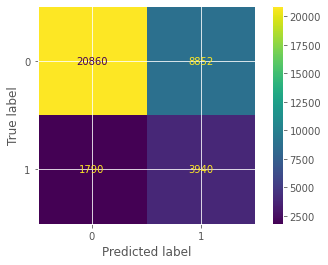

In [ ]:
plot_confusion_matrix(clf_weighted, X_test, y_test)  
plt.show()

In [ ]:
metrics.f1_score(y_test, prediction)

0.42544001727675196

In [ ]:
metrics.recall_score(y_test, prediction)

0.68760907504363

# ROC-AUC curve

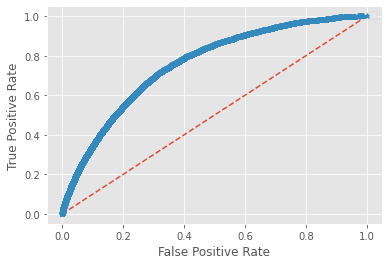

In [ ]:
# keep probabilities for the positive outcome only
yhat = clf_weighted.predict_proba(X_test)[:,1]
# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(y_test, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

# Расчет оптимального threshold 
* Для оптимизации модели

In [ ]:
gmeans = np.sqrt(tpr * (1-fpr))

In [ ]:
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.158103, G-Mean=0.699


Best Threshold=0.163002, G-Mean=0.697


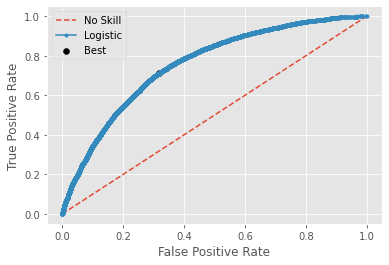

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, )
# calculate the g-mean for each threshold
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

# Blind set

In [ ]:
blindSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86755 entries, 170747 to 262686
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gender                86755 non-null  object 
 1   age                   86755 non-null  int64  
 2   marital_status        86755 non-null  object 
 3   job_position          86755 non-null  object 
 4   credit_sum            86755 non-null  float64
 5   credit_month          86755 non-null  int64  
 6   tariff_id             86755 non-null  float64
 7   score_shk             86755 non-null  float64
 8   education             86755 non-null  object 
 9   living_region         86755 non-null  object 
 10  monthly_income        86755 non-null  int64  
 11  credit_count          86755 non-null  float64
 12  overdue_credit_count  86755 non-null  float64
dtypes: float64(5), int64(3), object(5)
memory usage: 9.3+ MB


In [ ]:
blindSet = blindSet.drop_duplicates()

In [ ]:
blindSet.dropna(inplace=True)

In [ ]:
blindSet['score_shk'].replace(',', '.', regex=True, inplace=True)
blindSet['credit_sum'].replace(',', '.', regex=True, inplace=True)
blindSet = blindSet.astype({'credit_sum': float, 'score_shk': float})

In [ ]:
blind_set = blindSet.copy()

In [ ]:
encoded_blind = pd.get_dummies(
    blind_set, 
    columns=[
        'gender',
        'marital_status',
        'job_position',
        'education',
        'living_region'
        ]
)

In [ ]:
encoded_blind = encoded_blind.reindex(columns = X_train.columns, fill_value=0)

In [ ]:
blind_prediction = clf_weighted.predict(encoded_blind)

In [ ]:
blind_set['open_account_clf_clf_weighted'] = blind_prediction

In [ ]:
blind_set.open_account_clf_clf_weighted.value_counts()

0    54714
1    32041
Name: open_account_clf_clf_weighted, dtype: int64

In [ ]:
blind_set.to_csv('credit_test_results.csv')

In [ ]:
import pickle

with open('model.pkl', 'wb') as pickle_out:
    pickle.dump(clf_weighted, pickle_out)

In [ ]:
model_columns = list(X_train.columns)
with open('model_columns.pkl', 'wb') as pickle_columns_out:
    pickle.dump(model_columns, pickle_columns_out)

In [ ]:
df_new[df_new.living_region == 'nan']

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
client_id,,,,,,,,,,,,,,
